# Lesson 7 | Road to the Top & Collaborative Filtering
> Embeddings and Iterating on Work

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-02-21%20Fastai%20Lesson%207.ipynb)

## Lecture Content

### Road to the Top Lessons
Ok now its time to tackle the 'road to the top' series that Jeremy walks through as part of Lesson 6 and 7. I don't want to blindly follow the road to the top use case, and instead want to summarise the key ideas that I found useful for a competition 'workflow'

### Important Principles

#### 1. Iterate Fast and Small

Jeremy often finds a single activity that improves his scores, a change in model, or different architecture etc and then he submits the iteration. I always and easily fall into the habit of setting out 'a week' to focus on a huge set of ideas that I can come up with and often burn out or spin out. I'd like to focus on this single idea, iterate, submit loop. This is highlighted in Radek Osmulski's MetaLearning book which I love, its nice to see this in practice and an example to reference for an actual project instead of only an abstract idea which the scope of 'small' is unclear.


#### 2. Gradient Accumulation

I love this idea & innovation, I have a very small GPU that I'd like to upgrade at some point but this genuinely lets me squeeze every inch of memory from it and take on larger models and datasets. Here's a working example of the fastai feature.



Now because I have a stinky little GeForce GTX 960 from the great year of 2015 with 2GB of superpowers, I need to do this awesome thing called gradient accumulation.

This involves only updating the weights after many batches since I can only handle much smaller batches than the 32/64 that you'd usually want to train with and instead, adding/accumulating the gradients. This allows me to train an arbitrarily large/complicated model with whatever effective batch size I like without needing to stump up cash for renting GPU hours or building a whole new PC.

I've implemented this in the callbacks of my dataloader, in particular I think callbacks deserve their own post/blog as their crucial in the fastai library, [Zach Meuller](https://www.youtube.com/watch?v=DIYWATB4B0I) has an awesome video on exactly this. He's also another fastai alumn that I'm totally in awe of, fastai prints legends and I feel so lucky just to be able to read their content.

Also note the **`64//accum` instead of `64/accum`**, this is [integer/floor division in python](https://docs.python.org/3/glossary.html#term-floor-division) and always gives you a rounded down integer of your division result. Super nice little syntax and thought it worthwhile to highlight

In [ ]:
# install fastkaggle if not available
from fastai.vision.all import *
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
set_seed(17)

train_path = path/'train_images'
files = get_image_files(train_path)


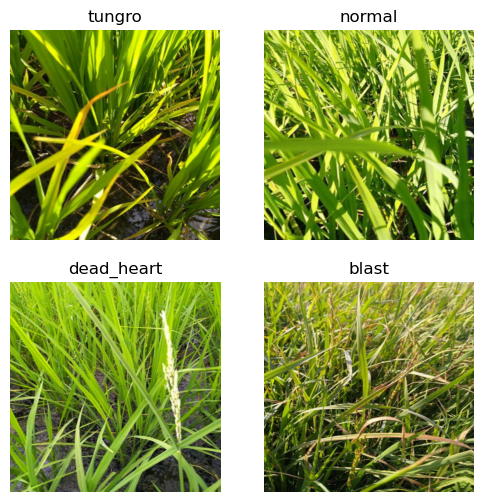

In [ ]:
accum = 16
dls = ImageDataLoaders.from_folder(train_path,
                                  valid_pct=0.2,
                                  seed=42,
                                  item_tfms=Resize(640,method='squish'),
                                  batch_tfms=aug_transforms(size=480, min_scale=0.75),
                                  bs=64//accum)

cbs = GradientAccumulation(64)
learn = vision_learner(dls=dls,
                       arch='resnet26d',
                       metrics=error_rate,
                       path=".",
                       cbs=cbs).to_fp16()

dls.show_batch()

The raw images in their original format and a sufficiently larger model than resnet would blow up my tiny GPU but with gradient accumulation, I can run more batches before calculating my loss.

#### 3. Test Time Augmentation

Another fascinating and effective innovation, simply put that at prediction time, you create augmentations of the object you want to predict against and average or max the prediction results from the set you receive.

Checkout the [fastai TTA docs](https://docs.fast.ai/learner.html#tta) for a quick explanation. A super simple idea but it makes a demonstrable difference in performance for the paddy competition that Jeremy presents in the road to the top series.

#### 4. Ensembling

Ensembling / Bagging is an important concept and I've simply neglected to ever implement it despite its fantastic efficacy and simplicity. I'm writing it here explicitly to make sure I don't forget to do so in the future!

#### 5. Embeddings as Inputs into Other Models

[From the original Embeddings paper](https://arxiv.org/pdf/1604.06737.pdf), its noted that embeddings when used as inputs for other models actually improves their performance, see the visual table below for the relative performance gains:



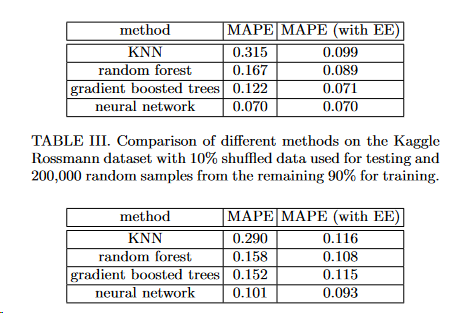

I think its amazing that these latent factors that start from random variables can contain predictive signals as well as help you understand your data once you condense the featurespace and look at them visually.

## Book Content

### Collaborative Filtering Deep Dive

I've worked through embeddings in [another blog of mine](https://nglillywhite.quarto.pub/nicks-blog/posts/2022-2-08-embeddings%20described%204%20ways.html) but I'd like to work through them again as part of due diligence for the course and to concrete in what I know and re-inforce what is shaky.

Collaborative filtering is a general solution to the problem of recommending similar products/actions/choices/items for a given user in your system. For example when you browse netflix, you will get recommended personalised shows in an order unique to you, this is a possible solution to this problem of giving recommendations.

As the book notes, a key idea is the concept of _latent factors_. I've interpreted them as concepts and features that exist but aren't exactly present in your data. For example in the context of movies, there are niche genres and subcultures within movie watching that aren't explicitly mentioned in genre lists or the movies themselves, an example being 90s neo noir/crime thrillers, think _Twin Peaks_, _Seven_, _Fallen Angels_. These are very different movies and shows that won't get classified as similar or having a shared origin but there is an aesthetic and film style between them that unites the fans of these films and shows. _Latent Factors_ are a way to attempt to discover these similarities and links in a higher dimensional space, they also help you learn more about your data and what kind of data points are conceptually linked in some way, and this all starts with random numbers, we'll get to that in a bit.

Continuing down the Movie theme and Netflix, we're going to use the MovieLens dataset that contains tens of millions of movie rankings with a movie ID, a user ID, and a rating. We'll only use 100K or so but this explains the domain and scale of the data we're using.

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [ ]:
ratings = pd.read_csv(path/"u.data", delimiter="\t",header=None,names=["user","movie","rating","timestamp"])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Ok so we don't know the movie IDs yet, thats ok, the important bit is that we can see any particular user has ratings they make for a given movie, lets take a look at user 196 and see their ratings.

In [ ]:
ratings[ratings.user==196].head()

,user,movie,rating,timestamp
0,196,242,3,881250949
940,196,393,4,881251863
1133,196,381,4,881251728
1812,196,251,3,881251274
1896,196,655,5,881251793


Lets grab the movies and have a look what these are

In [ ]:
movies = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1", usecols=(0,1), names=["movie","title"],header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


And finally the movies that user 196 has rated:

In [ ]:
movies[movies.movie.isin(ratings[ratings.user==196].head().movie)]

,movie,title
241,242,Kolya (1996)
250,251,Shall We Dance? (1996)
380,381,Muriel's Wedding (1994)
392,393,Mrs. Doubtfire (1993)
654,655,Stand by Me (1986)


These are some classics! Muriel's Wedding is an all-timer Australian movie and Stand by Me totally holds up after all these years. Please go watch both of these if you haven't!

### Where are we Going

What we want to end up with is a bunch of factors that represent for a movie or user, how highly a movie will be liked or a user will like a movie based on the genre etc. For example if we wanted to describe _The Phantom Menace_ as a genre vector, we might say we have a vector of 4, representing sci-fi, action, romance, and horror, ranging between -1 and +1, with +1 indicating a high match, it might look like the below:

In [ ]:
phantom_menace = np.array([0.99, 0.85, 0.4, -0.7])

Scoring highly on sci-fi, action, a little bit on romance, and lowly on horror, this might represent our star wars masterpiece (I love this movie, fight me if you don't).

We then might have a user, that we'd want to evaluate if they'd like the phantom menace (they should objectively but for example's sake lets do the math).

In [ ]:
user1 = np.array([0.9,0.8,0.2, -0.5])

We can then calculate the dot product between the two and see if they're likely to enjoy the movie

In [ ]:
(phantom_menace * user1).sum()

2.0010000000000003

If we then had another movie, say _Happy Feet_ which scored more highly on horror and romance:

In [ ]:
happy_feet = np.array([-0.99,-0.4,0.97,0.98])

(happy_feet * user1).sum()

-1.5070000000000001

We'd have a much lower score, because its so frightening to see George Miller not making more Mad Max movies when he can.

This however does give us some nice mathematical way to evaluate whether a user and movie are a good match for each other, as well as the type of movie you have and the type of movie goer and how they rate what they watch

### Learning Latent Factors

Ok when wanting to build these latent factors, we can use the magic of gradient descent to find out what the correct values should be since we don't know that phantom menace should be a '0.98' on action by any obvious means _yet_.

1. The first thing to do is to randomly build some initial parameters
     - These will be a set of factors for each movie and user, we can start with 5 for each respectively but in the future will decide more intelligently how to size these embeddings.
2. Calculate our Predictions
     - Take the dot product of our values, this gives us our prediction
3. Calculate our Loss
     - We can consider these latent factors input parameters and use SGD, like we would for model parameters to minimise the loss. We'll calculate the distance between the latent factor and the actual prediction the user made for a given movie.

### Making our DataLoaders

Lets merge our ratings and movies together to start

In [ ]:
ratings = ratings.merge(movies)

In [ ]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name="title", bs=64)
dls.show_batch()

,user,title,rating
0,745,Rear Window (1954),4
1,355,Wishmaster (1997),4
2,863,Mat' i syn (1997),1
3,356,"English Patient, The (1996)",3
4,197,G.I. Jane (1997),3
5,64,Contact (1997),3
6,354,Rosencrantz and Guildenstern Are Dead (1990),4
7,215,Contact (1997),3
8,255,Crash (1996),1
9,825,Raiders of the Lost Ark (1981),5


Lets look at the classes that our `CollabDataLoaders` builds for us

In [ ]:
dls.classes.keys(), type(dls.classes), dls.classes["user"][:2], dls.classes["title"][:2]

(dict_keys(['user', 'title']),
 dict,
 (#2) ['#na#',1],
 (#2) ['#na#',"'Til There Was You (1997)"])

Ok so we have a big dictionary, with our users and titles, with some examples to begin, our first user and our first movie.

We now want to build 5 random factors for each movie and each user

In [ ]:
n_users = len(dls.classes["user"])
n_movies = len(dls.classes["title"])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

For any particular movie and user combination, we need to look up that user's factors, and that movie's factors and dot product them together.

However how do we do that in our deep learning model, it has no concept of 'looking up an index', it matrix multiplies parameters by an input, and calculate activations.

The magic trick is that we can represent a lookup in an index as a matrix product. We instead replace our indices with one-hot-encoded vectors, [checkout this quick wiki](https://en.wikipedia.org/wiki/One-hot) if one-hot is a new term. All it means is that for n_classes, you encode a 1 in the instance of your particular category instead of having a single series with a 1-n_classes integer representing your class.

An example below is the user 3, one hot encoded by the number of users we have

In [ ]:
doc(one_hot)

In [ ]:
one_hot(3,n_users).float()

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

If we then matrix multiply this one hot encoded matrix by our user factors, we get a 'lookup in an index' effect.

In [ ]:
user_factors.t() @ one_hot(3, n_users).float()

tensor([ 1.0311,  1.9365, -0.5739,  0.0107, -0.2019])

In [ ]:
user_factors[3]

tensor([ 1.0311,  1.9365, -0.5739,  0.0107, -0.2019])

This kind of blows my brain as to how you can get a programmatic way to lookup an index in a tensor just by one-hot encoding the lookup as a matrix and then mutliplying together. It makes sense once you think about it but its a cool trick.

Now if we wanted to implement this, it would be computationally expensive as we're storing an incredible amount of useless data we don't want to use, most libraries like PyTorch include a special layer that replicates this exact behaviour but much faster, it calculates the derivative in such a way that its identical to what we would get with our one hot encoding trick.

This is an **_embedding or embedding matrix_**

Remember that we don't know what values to apply to these factors, and also remember they could represent lots of underlying features, ie how much dialogue is present, how many a-listers are in the movie, how dark the movie is etc. Instead we're going to learn appropriate values with SGD.

### Creating a PyTorch Module

An important process in Pytorch is to be able to construct the model architecture from scratch. Thankfully they make this quite easy with inheritance from the `Module` class but its great to be able to do it by hand for something simple like an embedding module since in the future I'd like to implement more complicated architectures from papers and modify them etc. This is impossible without being comfortable with the PyTorch API and modification of the model architectures.

Lets make our DotProduct module

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Note our model takes a tensor that is our `batch size x 2` since the first column contains the user ID `x[:,0]` and the second contains the movie ID `x[:,1]`, we're using our embedding layers to represent our matrices of users and movies.

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

Ok we have our model architecture, we need to make our `Learner` object which will manage our training loop and optimise our model.

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

Lets fit our model!

In [ ]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.301913,1.300614,00:13
1,1.069615,1.085257,00:10
2,0.958619,1.000044,00:10
3,0.853051,0.902324,00:10
4,0.775018,0.884577,00:10


Ok this looks cool, we're learning and our predictions are getting better over time. However think about how some individual users just love movies and in general rate more highly than others. A 5 to one person is not the same as a 5 for another person. We can introduce a 'bias' term which allows us to correct for overly negative or positive reviewers. Lets adjust our model score to incorporate this bias.

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users,1)
        
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users*movies).sum(dim=1,keepdim=True)
        
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Ok we've introduced a bias term which we add to our previous dot product function and we also sigmoid the results between 0 and 5.5, lets retrain and see how we go

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.942555,0.936341,00:11
1,0.834424,0.860406,00:11
2,0.618835,0.857702,00:11
3,0.415448,0.887348,00:11
4,0.290656,0.894148,00:11


Hey woah our validation loss starts blowing up, what gives?! Our training loss is improving but we're getting worse in our validation set. Looks like we might be overfitting, there's a couple of ways to deal with over-fitting but since we can't augment our data, we'll have to regularise some other way.

A common method is called weight decay or L2 regularisation

### Weight Decay | L2 Regularisation

L2 is done by adding into your loss function, a square of all the summed weights, this means that when the gradient is computed, it will add a contribution to them which encourages the weights to be as small as possible. This helps manage overfitting because the bigger our weights are, the sharper we move down our gradient with our loss function because we'll take a bigger steps with a bigger loss.

Limiting our weights will impact training to a degree but we'll generalise better which is our intended goal. In fastai we can implement this simply by passing the `wd` parameter to our `fit_one_cycle` method.

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.941463,0.947428,00:11
1,0.845775,0.875592,00:11
2,0.741966,0.834393,00:12
3,0.596748,0.820696,00:11
4,0.498071,0.821762,00:11


And we're cooking with gas, absolutely smoked our previous trials, even with a much higher training loss, awesome.

### Embeddings from Scratch

Lets now implement the previous model we made  but without the native `Embedding` objects that PyTorch provides. Remember that we need to make our parameters with the `nn.Parameter` class and method instead of just `torch.tensor` like functions.

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

Awesome, we can see our `self.a` attribute requires a gradient and is available as a parameter for PyTorch to optimise.

Lets make a `create_params` helper method which gives us this parameter shortcut and then re-build the DotProductBias class

In [ ]:
def create_params(size): return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.919432,0.947903,00:12
1,0.838106,0.869452,00:13
2,0.737761,0.827729,00:12
3,0.595462,0.819527,00:11
4,0.473325,0.820041,00:11


And we're back down to a similar validation loss, its cool to see how some of these concepts are so simple but so powerful. Also really nice how the PyTorch API has these out of the box and they're so easy to implement.

### Interpreting Embeddings

One of the things I mentioned earlier is that embeddings help you understand your data and the relationships between movies, we're going to work through this process now. The first thing to look at is the biases for movies, if there's a low bias, this implies that even well matched users still didn't like the movie. It tells us not only its a bad movie (which an average rating might give you) but that people who should like the movie also don't like it.

In [ ]:
# Get rid of any bias dimensions of length 1
movie_bias = learn.model.movie_bias.squeeze()

# Grab the first 5 indexes of movies, sorted by ascending bias
idxs = movie_bias.argsort()[:5]

# Grab the title from the classes dict for each of the indexes
[dls.classes["title"][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 "McHale's Navy (1997)",
 'Home Alone 3 (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Jury Duty (1995)']

These are some all time horrific movies, Home Alone 3 seems out of place but its not great.

Lets now checkout the reverse, which would be great movies that everyone liked, even those that might not like these sorts of movies

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

["Schindler's List (1993)",
 'Titanic (1997)',
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)',
 'As Good As It Gets (1997)']

These are objectively brilliant movies, Cool to see that tensors of random variables, learn to figure this out.

Lets now condense the amount of dimensions from our embeddings using PCA in order to see what movies are 'close' to each other in space

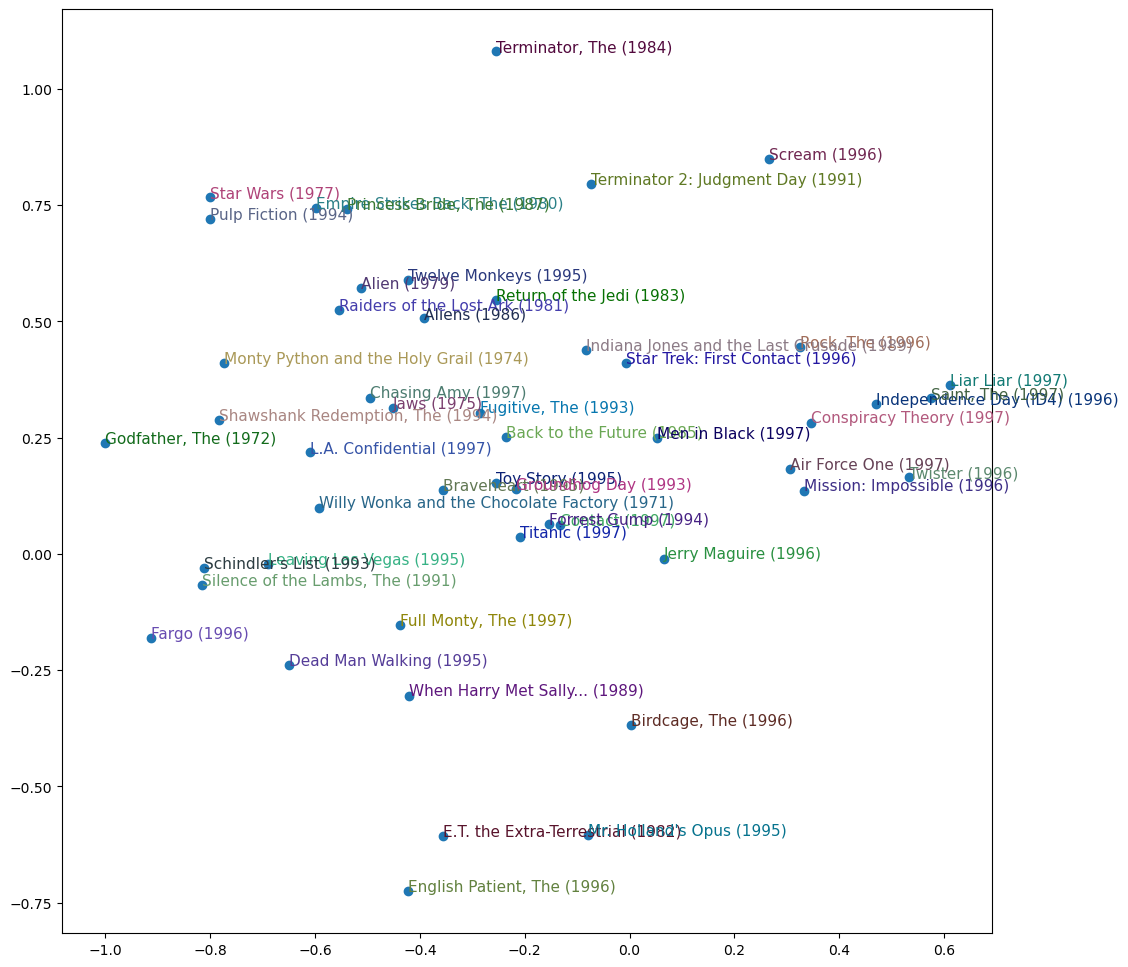

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)

fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))

X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X,Y)

for i,x,y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Lots of action comedies to the right, lots of murder to the bottom left, lots of sci-fi up top. Super interesting to see the groupings.

We can do all of this from the top level fastai library collab_learner which we can re-implement below:

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.957006,0.950044,00:11
1,0.846256,0.871980,00:11
2,0.744961,0.827820,00:11
3,0.580003,0.816122,00:11
4,0.498882,0.816902,00:11


We can replicate the bias investigation we did before

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Good Will Hunting (1997)',
 'As Good As It Gets (1997)']

Looks very similar to our 'best of' list before

### Moving to Deep Learning

In order to progress from our module to a deep learning model, we need to take the results from our embedding lookup and 'concatenate those activations together', this gives us a matrix which we can then feed into our model like any other input.

fastai has an embedding size generator for you that we can use, `get_emb_sz(dls)`

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [ ]:
doc(get_emb_sz)

And lets implement our prior work as well as some linear layers

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act,1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs,dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
model = CollabNN(*embs)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.808936,0.876346,00:13
1,0.851608,0.871176,00:13
2,0.835672,0.861963,00:13
3,0.760331,0.836720,00:13
4,0.709724,0.841264,00:13


It does pretty good, not quite as good as before but its still improving.

`fastai.collab` lets you add more layers to your model easily with the `use_nn=True` parameter where you can pass the linear layer sizes you'd like to add

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.980951,0.971177,00:14
1,0.927234,0.912022,00:14
2,0.862689,0.877535,00:14
3,0.822295,0.857404,00:13
4,0.776767,0.857582,00:13


### Conclusion

Another fun lesson, I learnt heaps about a better competition workflow for kaggle and its nice to refresh embeddings and build some PyTorch model architectures from scratch, thanks for reading.